In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, precision_score, roc_auc_score, recall_score, average_precision_score
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
y_train = pd.read_csv('../fraud_detection/active_datasets/y_train.csv', header=None).to_numpy().ravel()
y_test = pd.read_csv('../fraud_detection/active_datasets/y_test.csv', header=None).to_numpy().ravel()

In [3]:
X_train = pd.read_csv('../fraud_detection/active_datasets/fff_train.csv', header=None).to_numpy()
X_test = pd.read_csv('../fraud_detection/active_datasets/fff_test.csv', header=None).to_numpy()

In [4]:
sum(y_test), len(y_test), sum(y_test)/len(y_test)

(1750, 148661, 0.011771749147389026)

In [5]:
train_fraud_rate = sum(y_train)/len(y_train)

In [6]:
batch_size = 20/train_fraud_rate
batch_num = len(X_train)//batch_size + 1
print(batch_num)

273.0


In [7]:
X_training_batches = np.array_split(X_train, batch_num)
y_training_batches = np.array_split(y_train, batch_num)
np.mean([y.sum() for y in y_training_batches])

19.963369963369964

In [8]:
def score(y_pred, y_true):
        scores = {}
        evaluation_funcs = {'accuracy':accuracy_score, 'precision':precision_score, 'recall':recall_score, 'f1':f1_score, 'MCC':matthews_corrcoef}
        for name, score in evaluation_funcs.items():
                scores[name] = score(y_pred = y_pred, y_true = y_test)
        scores['ROC-AUC'] = roc_auc_score(y_score = y_pred, y_true = y_test)
        scores['AUPR'] = average_precision_score(y_score = y_pred, y_true = y_test)
        return scores

In [9]:
scores = []
for k in range(1, int(np.log2(len(y_test)))):
    LOF = LocalOutlierFactor(n_neighbors=2**k, contamination=sum(y_train)/len(y_train))
    y_pred = LOF.fit_predict(X_test)
    y_pred = list(map(lambda x: {-1:1, 1:0}[x], y_pred))
    scores.append(score(y_pred, y_test))
    k += 1

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [17:11:50<00:00, 30.96s/it]  


<AxesSubplot: >

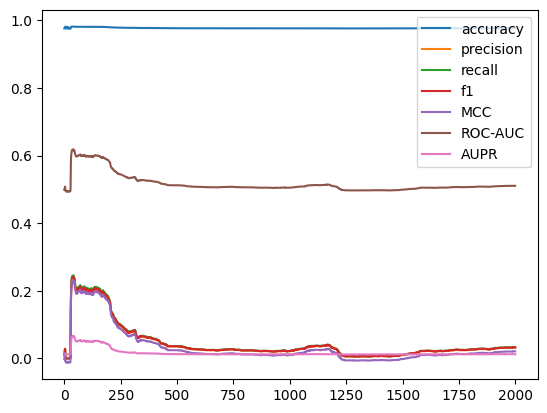

In [10]:
pd.DataFrame(scores).plot()